In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport src

In [3]:
cd ..

/home/mars/src_aiai


In [26]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from src.data import load_M51
from src.operators.NUFFT2D import NUFFT2D #, MeasurementOperatorDiscrete
from src.operators.dictionary import wavelet_basis #, MeasurementOperatorDiscrete

from src.sampling.uv_sampling import spider_sampling # RadialSampling, SpiderSampling, SpiderSampling2
from src.solvers import PrimalDual_l1_constrained

imshow_kwargs = {"cmap":'gray'}

In [ ]:
import tqdm

In [125]:
x_true = np.load("./data/intermediate/COCO/NUFFT_SPIDER/x_true_test_30dB.npy")[4]


In [137]:
y1 = np.load("./data/intermediate/COCO/NUFFT_SPIDER/y_dirty_test_30dB.npy")[4]


In [144]:
ISNR = 30 # very low noise

x = np.load("./data/intermediate/COCO/NUFFT_SPIDER/x_true_train_30dB.npy")
sigmas = [ np.sqrt(np.mean(np.abs(op_nufft8.dir_op(i))**2)) * 10**(-ISNR/20) for i in x]
np.save("./data/intermediate/COCO/NUFFT_SPIDER/noise_values_train_30dB.npy", sigmas)

x = np.load("./data/intermediate/COCO/NUFFT_SPIDER/x_true_test_30dB.npy")
sigmas = [ np.sqrt(np.mean(np.abs(op_nufft8.dir_op(i))**2)) * 10**(-ISNR/20) for i in x]
np.save("./data/intermediate/COCO/NUFFT_SPIDER/noise_values_test_30dB.npy", sigmas)


In [66]:
ISNR = 30 # very low noise
sigmas = [ np.sqrt(np.mean(np.abs(op_nufft8.dir_op(i))**2)) * 10**(-ISNR/20) for i in x]


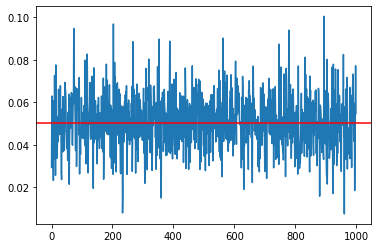

In [90]:
plt.plot(sigmas)
plt.axhline(0.05, c='r')

In [107]:
np.where(np.array(sigmas) > 0.08)

(array([ 73, 117, 203, 267, 319, 353, 388, 563, 747, 779, 832, 894, 904,
        958]),)

In [68]:
np.mean(sigmas)

0.050722319102695146

In [98]:
Nd=(256,256) # input image size 
Kd=(512,512) # oversampled k-space size
Jd=(6,6) # interpolation kernel size

vis = spider_sampling() # using Duncan et al. configuration

op_nufft8 = NUFFT2D()
op_nufft8.plan(vis, Nd, Kd, (6,6)) # for measurements
op_nufft4 = NUFFT2D()
op_nufft4.plan(vis, Nd, Kd, (6,6)) # for reconstruction


100%|██████████| 4440/4440 [00:00<00:00, 6645.26it/s]


## Generating noisy data

In [140]:
# y0 = op_nufft8.dir_op(x_true) # measurements using J=8
# y0 = y1
# # creating noisy data
# ISNR = 30 # very low noise
# sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20) 
# n = np.random.normal( 0, sigma, y0.shape) + 1j * np.random.normal( 0, sigma, y0.shape)
# y = y0 + n /np.sqrt(2)
y = y1

In [141]:
np.linalg.norm(n/np.sqrt(2))/np.sqrt(4440), sigma

(0.050568386007414416, 0.05038807156096139)

In [112]:
sigma

0.09469337864295486

Text(0.5, 1.0, 'difference w/ and w/o noise')

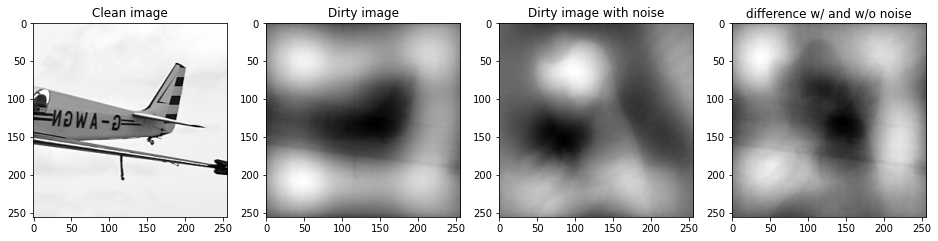

In [113]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
ax[0].imshow(x_true, **imshow_kwargs)
ax[0].set_title("Clean image")
ax[1].imshow(op_nufft4.adj_op(y).real, **imshow_kwargs)
ax[1].set_title("Dirty image")
ax[2].imshow(op_nufft4.adj_op(noisy_y).real, **imshow_kwargs)
ax[2].set_title("Dirty image with noise")
ax[3].imshow(op_nufft4.adj_op(y).real - op_nufft4.adj_op(noisy_y).real, **imshow_kwargs)
ax[3].set_title("difference w/ and w/o noise")


In [38]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error


## solving with constrained solver

In [127]:
psi = wavelet_basis(x_true.shape)

noise_val = 0.05
solver = PrimalDual_l1_constrained(m_op=op_nufft8, psi=psi, beta=1e-5,
    options={
        'tol': 1e-6, 'iter': 300, 'update_iter': 500, 
        'record_iters': False, 'positivity': True, 'real': True})

{'tol': 1e-06, 'iter': 300, 'update_iter': 500, 'record_iters': False, 'positivity': True, 'real': True}


In [53]:
print(sigma, noise_val)

0.05035391435997628 0.05


In [ ]:
256,256

In [75]:
x.max()

1.0

In [62]:
np.sqrt(4440 + 2 * np.sqrt(4440))

67.6259317864949

$\epsilon = \sqrt{M + 2 \sqrt{M}}$

In [142]:
result, diag = solver.solve(y, op_nufft4, sigma)

2022-06-27 14:47:33,021 - Optimus Primal - INFO - Starting Power method


INFO:Optimus Primal:Starting Power method


2022-06-27 14:47:33,269 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0


INFO:Optimus Primal:[Power Method] iter = 1, tol = 0.0


2022-06-27 14:47:34,242 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0


INFO:Optimus Primal:[Power Method] iter = 11, tol = 0.0


2022-06-27 14:47:34,510 - Optimus Primal - INFO - [Power Method] Converged with norm= 5.777700309414663, iter = 14, tol = 0.0009691823998384676


INFO:Optimus Primal:[Power Method] Converged with norm= 5.777700309414663, iter = 14, tol = 0.0009691823998384676


2022-06-27 14:47:34,594 - Optimus Primal - INFO - Running Forward Backward Primal Dual


INFO:Optimus Primal:Running Forward Backward Primal Dual


2022-06-27 14:47:34,727 - Optimus Primal - INFO - [Primal Dual] 0 out of 300 iterations, tol = 0.590767


INFO:Optimus Primal:[Primal Dual] 0 out of 300 iterations, tol = 0.590767
DEBUG:Optimus Primal:[Primal Dual] 0 out of 300 iterations, tol = 0.590767
DEBUG:Optimus Primal:[Primal Dual] 1 out of 300 iterations, tol = 0.193608
DEBUG:Optimus Primal:[Primal Dual] 2 out of 300 iterations, tol = 0.295897
DEBUG:Optimus Primal:[Primal Dual] 3 out of 300 iterations, tol = 0.273573
DEBUG:Optimus Primal:[Primal Dual] 4 out of 300 iterations, tol = 0.176250
DEBUG:Optimus Primal:[Primal Dual] 5 out of 300 iterations, tol = 0.130262
DEBUG:Optimus Primal:[Primal Dual] 6 out of 300 iterations, tol = 0.106909
DEBUG:Optimus Primal:[Primal Dual] 7 out of 300 iterations, tol = 0.079867
DEBUG:Optimus Primal:[Primal Dual] 8 out of 300 iterations, tol = 0.066208
DEBUG:Optimus Primal:[Primal Dual] 9 out of 300 iterations, tol = 0.062106
DEBUG:Optimus Primal:[Primal Dual] 10 out of 300 iterations, tol = 0.056216
DEBUG:Optimus Primal:[Primal Dual] 11 out of 300 iterations, tol = 0.046765
DEBUG:Optimus Primal:[Pr

### Results 

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


Text(0.5, 1.0, 'Residuals (PSNR:21.135027695773264)')

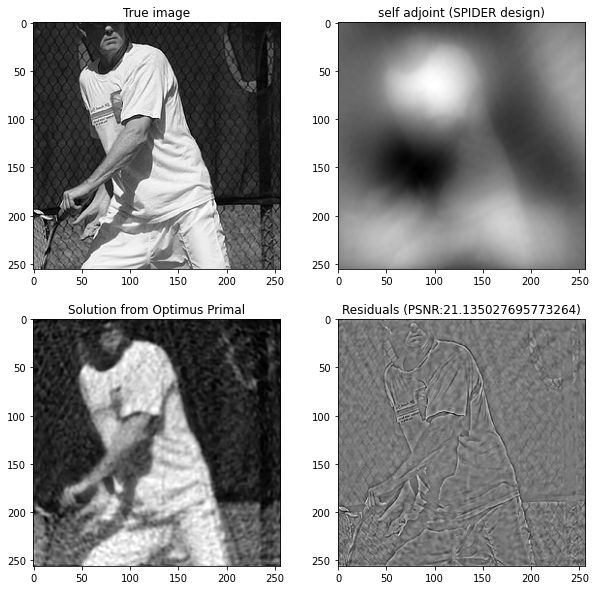

In [143]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.adj_op(op_nufft4.dir_op(x_true)).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (PSNR:{peak_signal_noise_ratio(x_true, result)})")


### Analysing optimisation

Text(0.5, 0, 'iterations')

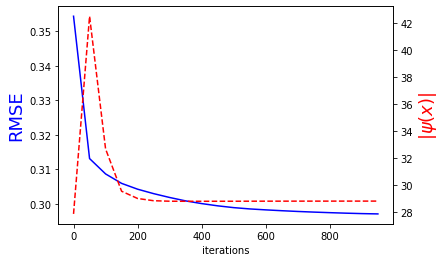

In [11]:
hs = diag2['hs']
xs = np.array(diag2['xs']) 

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

It moves away from the minimum instead of converging. The local minimum looks like this:

Text(0.5, 1.0, 'Residuals (RMSE:2.9711e-01)')

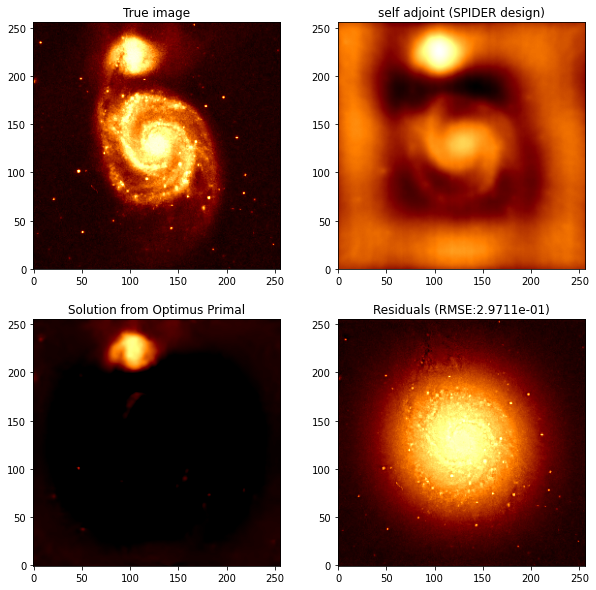

In [12]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

## solving with unconstrained solver

In [13]:
options={'tol': 1e-5, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': False, 'real': False}
result3, diag3 = l1_unconstrained_solver(noisy_y, op_nufft4, sigma, options=options) # solver is hardcoded for n

2021-03-27 14:27:14,154 - Optimus Primal - INFO - Starting Power method
2021-03-27 14:27:14,206 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-27 14:27:14,446 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-27 14:27:14,682 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-27 14:27:14,825 - Optimus Primal - INFO - [Power Method] Converged with norm= 2.868441, iter = 27, tol = 0.000965014
2021-03-27 14:27:14,909 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-27 14:27:15,020 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.007617
2021-03-27 14:27:20,182 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.006760
2021-03-27 14:27:25,380 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.004163
2021-03-27 14:27:30,744 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.002787
2021-03-27 14:27:35,979 - Optimus 

### Results

Text(0.5, 1.0, 'Residuals (RMSE:3.4181e-01)')

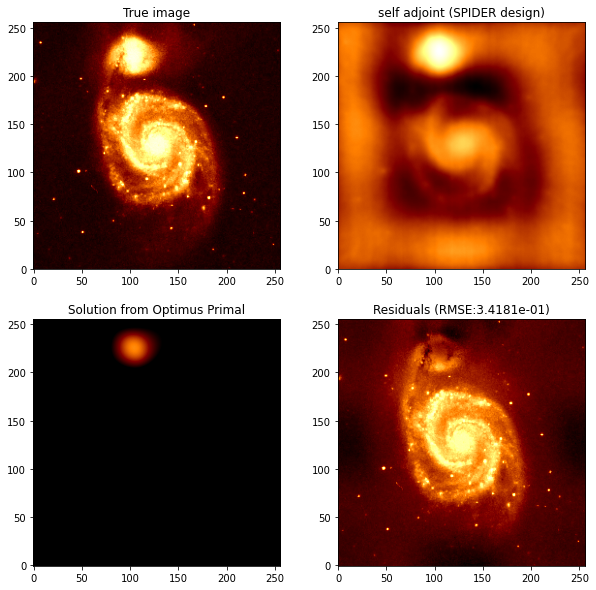

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result3.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result3.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result3.real))):.4e})")

### Analysing optimisation path

Text(0.5, 0, 'iterations')

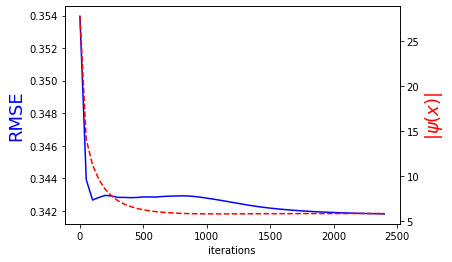

In [15]:
hs = diag3['hs']
xs = np.array(diag3['xs']) 
fs = diag3['fs']

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
# ax.plot(np.arange(0,5000, 50)[:len(fs)], fs, 'b-')

ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

# plt.axis(xmin = 200)

Text(0.5, 1.0, 'Residuals (RMSE:3.4181e-01)')

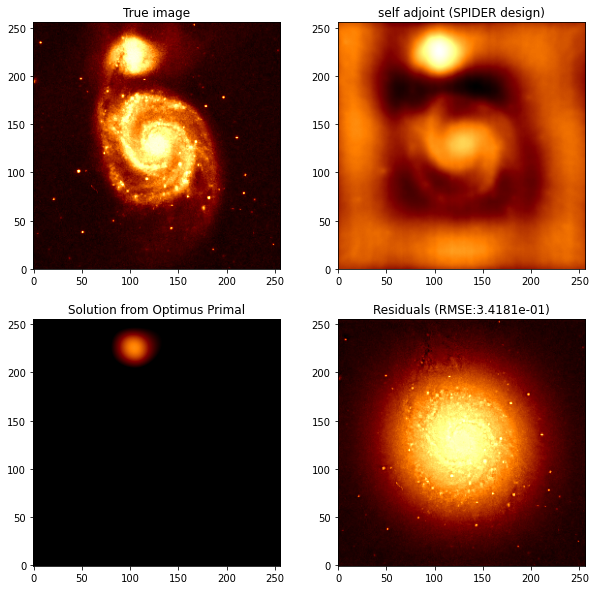

In [16]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

The unconstrained solver doesn't seem to converge to the solution at all. This is probably a problem with scaling the regularisation